In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
df = pd.read_csv('2025-6-25公众号Python机器学习AI.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,0,4,140,241,0,0,123,1,0.2,2,0,2,1
293,45,1,1,110,264,0,0,132,0,1.2,2,0,2,1
294,68,1,4,144,193,1,0,141,0,3.4,2,2,2,1
295,57,1,4,130,131,0,0,115,1,1.2,2,1,2,1


In [2]:
from sklearn.model_selection import train_test_split

# 划分特征和目标变量
X = df.drop(['target'], axis=1)  
y = df['target']  
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y, 
    test_size=0.3, 
    random_state=42, 
    stratify=df['target'] 
)

假设你有1000条数据  
subsample=0.8 时：  
第1棵树：随机选800条数据训练（比如选了1-800号）  
第2棵树：重新随机选800条数据训练（这次可能是200-1000号）  
第3棵树：再随机选800条数据训练（可能是150-950号）  
...  
每棵树都看到不同的数据子集  


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
import xgboost as xgb

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier(random_state=42)
# 这里创建了一个XGBoost分类器模型，用于分类任务

# 定义超参数网格
param_grid = {
    'max_depth': [3, 6, 9],            # 树的最大深度，较深的树可以学习更复杂的模式，但可能会过拟合
    'learning_rate': [0.01, 0.1, 0.2], # 学习率，模型学习的速度。较小的值需要更多的树，但通常能得到更好的结果
    'n_estimators': [100, 200],        # 弱学习器（树）的数量，模型中的决策树数量。更多的树通常会提高性能，但会增加计算时间
    'subsample': [0.8, 1.0],           # 数据子样本比率
    'colsample_bytree': [0.8, 1.0],    # 每棵树的特征子样本比率
}
# max_depth：树的深度就像吉他弦的松紧，太松（3）可能太简单，太紧（9）可能过拟合
# learning_rate：学习速度像开车油门，0.01是慢速稳当，0.2是快速但可能错过最佳路线
# n_estimators：树的数量像合唱团人数，100人可能不够响亮，200人可能和谐度更高
# subsample：数据子样本比率像选取乐器的数量，0.8是大部分乐器，1.0是全部乐器
# 正常训练：每棵树都用100%数据 → 树树相似 → 过拟合风险高
# 随机抽样：每棵树用不同80%数据 → 树树不同 → 提高泛化能力
# colsample_bytree：每棵树用多少特征，0.8用80%特征增加多样性

# 基于经验，我们知道：
# - max_depth超过10容易过拟合
# - learning_rate超过0.3可能不稳定
# - 所以只测试合理范围
# ⭐所以我们定义超参数网格只是事先设定的范围，实际调优时会自动选择最佳组合。
# 没有param_grid，**GridSearchCV会报错！也有可能是会选择默认的参数，但是这样不好

# 使用KFold进行k折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',    # 使用AUC评估模型
    cv=kf,                # K折交叉验证
    verbose=1,            # 输出进度
    n_jobs=-1             # 使用所有可用的CPU核心
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最佳参数组合
print("最佳超参数:", grid_search.best_params_)

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
最佳超参数: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}


XGBoost分类器完整指南（超小白版）  
XGBoost = 超级加强版的决策树森林  
想象一下：你不是问一个人意见，而是问100个专家，每个专家都经验丰富，他们投票决定最终结果  
现在，我们不只找小明和小红，我们找来了一大群学生（比如几百个）  
第一个学生（树1）先来猜，他肯定会犯很多错误。  
我们记录下他所有猜错的例子，然后告二个学生（树2）：“听着，这些是‘难题’，你重点解决它们  
第二个学生（树2）就在这些“难题”上使劲，建立自己的判断规则。他可能解决了部分难题，但又会产生新的错误  
这个过程不断重复，直到我们有了一个庞大的学生团队  
最后一起投票决定来决定哪些是最好的预测因素哪个决策树是最好的  


  


In [ ]:
import shap
# SHAP是一个用于解释机器学习模型的Python库
# SHAP = SHapley Additive exPlanations（沙普利加性解释）
# 它可以告诉你：模型的每个特征对预测结果贡献了多少
explainer = shap.TreeExplainer(best_model)
# TreeExplainer 是专门用于树模型（如XGBoost、随机森林等）的解释器
# 它会计算每个特征对每个预测的贡献值
# 计算训练集的SHAP值
# best_model 是你之前训练好的最佳XGBoost模型
# 这一步相当于给模型安装一个"翻译器"，让它能够解释自己的决策过程
shap_values = explainer.shap_values(X_test)
# 对测试集 X_test 中的每个样本计算SHAP值
# SHAP值告诉你：每个特征对每个预测结果的具体贡献

# 通俗理解 想象你是一个医生，要诊断病人是否有心脏病
# 传统模型：直接告诉你"这个病人有70%概率患心脏病"
# SHAP解释：告诉你具体原因
# 年龄因素：+0.2（增加风险） 血压因素：+0.1（增加风险） 运动量因素：-0.15（降低风险） 胆固醇因素：+0.05（轻微增加风险）
# 正值：该特征增加了预测为正类的概率
# 负值：该特征降低了预测为正类的概率
# 绝对值大小：表示该特征的重要程度

In [ ]:
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_df.head()
# 请解释为什么这串代码最后得到的表格中每个特征值会对应好几个shap解释值
# 每个特征值对应多个SHAP解释值是因为每个样本的SHAP值都是独立计算的
# 而不是针对每个特征的固定值。具体来说：
# - 每一行代表一个测试样本
# - 每一列代表一个特征
# - 每个单元格的值是该样本中该特征的SHAP贡献值
# 举个例子来说明
# 假设有3个病人的年龄数据：

# 病人1：年龄45岁 → age的SHAP值 = -0.086 (降低患病概率)
# 病人2：年龄55岁 → age的SHAP值 = 0.546  (增加患病概率)  
# 病人3：年龄35岁 → age的SHAP值 = -0.183 (降低患病概率)

# 所以age特征就会有3个不同的SHAP值

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-0.086040,0.168004,0.720131,-0.266921,-0.544889,0.016534,-0.207433,-0.003498,-0.556627,-0.290821,0.193414,-0.958299,-1.468862
1,0.546410,0.155884,0.947839,0.141968,0.294817,0.022276,0.417922,0.060143,0.435666,1.034441,0.429604,1.119966,1.039337
2,-0.182627,-0.375670,-0.885827,0.585744,-0.617936,0.015506,-0.322744,-0.214397,-0.086362,-0.182013,-0.359726,-0.503666,-0.602612
3,0.398233,-0.620359,-0.614585,0.068071,-0.198259,0.020868,-0.254544,-0.182860,-0.075949,-0.368951,-0.393294,-0.558306,-0.825910
4,1.735723,0.180422,-0.853027,-0.141139,-0.373004,0.057811,0.501282,-0.006633,-0.078385,-0.224521,-0.312774,1.185715,-0.635276


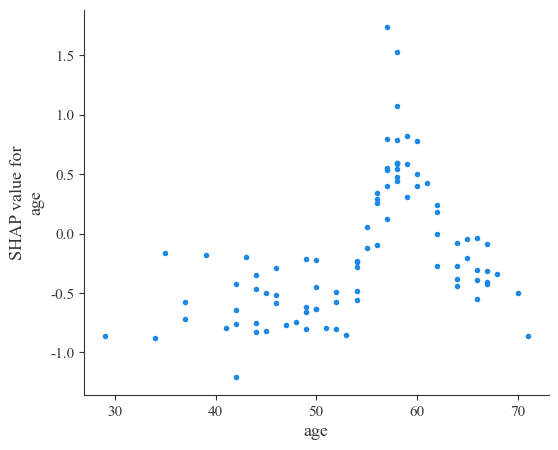

In [6]:
# 绘制 'age' 特征与 SHAP 值之间的关系图
shap.dependence_plot('age', shap_values, X_test, show=False, interaction_index=None)
plt.savefig('age_shap_dependence_plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')

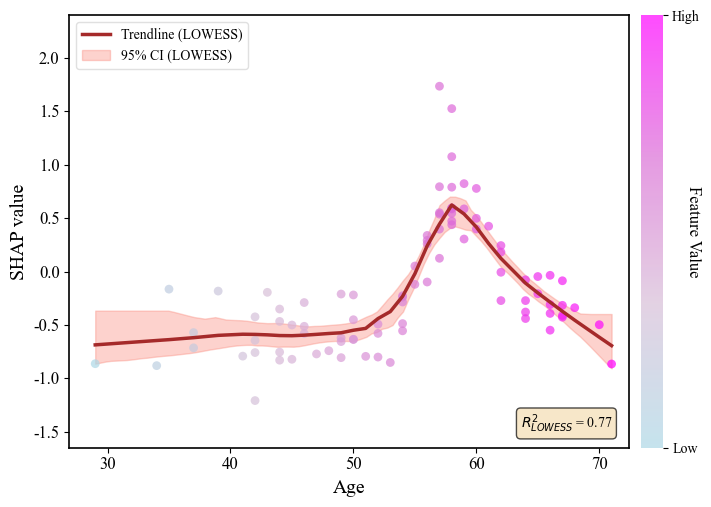

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial
from matplotlib.colors import LinearSegmentedColormap  # 导入自定义颜色映射所需的库
import matplotlib.cm as cm  # 导入cm模块

# 选择的特征
feature_to_plot = 'age'#我们给 'age' 这个名字贴上了这个标签
# 这里可以替换为其他特征名，如 'cholesterol', 'blood_pressure' 等

# 提取数据
X_data_orig = X_test[feature_to_plot].values#从一个名为 `X_test` 的数据集中，把所有 ‘age’ 这一列始数取出来

Y_data_orig = shap_values_df[feature_to_plot].values#从一个名为 `shap_values_df` 的数据集中，也把 ‘age’ 这一列的数值提取出来


# 过滤NaN/Inf
valid_indices_orig = np.isfinite(X_data_orig) & np.isfinite(Y_data_orig)
#np.isfinite() 会检查每个数据点是不是一个正常的、有限的数字
# 所以这行代码的意思是：“__只有当一个数据点的年龄值和它的SHAP值都是正常数字时，我们才认为它是有效
X_data = X_data_orig[valid_indices_orig]
Y_data = Y_data_orig[valid_indices_orig]

if len(X_data) < 2:
    print(f"特征 '{feature_to_plot}' 的有效数据点不足以绘图。")
    fig, ax = plt.subplots(figsize=(7, 5.5))
    ax.text(0.5, 0.5, f"数据不足: {feature_to_plot}", ha='center', va='center')
    plt.show()
    import sys
    sys.exit()

# LOWESS 拟合 
lowess_frac = 0.4
# frac参数控制LOWESS平滑的程度，0.4表示使用40%的数据点进行局部加权回归
# 值越小，曲线就越“贴近”每一个数据点，可能会显得很曲折
# 值越大，曲线就越平滑，可能会忽略一些局部变化
# 0.4意味着算法在计算曲线上某一点时，会参考它周围 40% 的数据点
# 这是一个经验性的选择，用来平衡曲线的平滑度和对数据的拟合度

sort_idx_main = np.argsort(X_data) # 把“年龄”从小到大排队，返回一张“排队顺序表”（索引表）
X_sorted_main = X_data[sort_idx_main]
Y_sorted_main = Y_data[sort_idx_main]# 按刚才的顺序表，把“年龄”和对应的 SHAP 值重新排好队，方便后面画线时不乱

r_squared_lowess = np.nan
# 先给“LOWESS 曲线的拟合优度”留个空盒子，后面算出来再填
# R²（拟合优度）就是 评分卡：
# 0 分表示曲线跟瞎猜没区别，1 分表示曲线完美穿过所有豆子
# 0.5 分表示曲线大致跟豆子走向一致，但有
# 一些豆子偏离曲线
# 这个分数写在论文里，别人一看就知道模型解释力好不好
lowess_interpolation_function = None
# 先给“LOWESS 插值函数”留个空盒子，后面算出来再填
# 插值函数更像 一把“刻度尺”
# 你把任意年龄输进去，它立刻告诉你对应曲线上的 y 值
main_lowess_fit_points = None
# 先给“LOWESS 拟合点”留个空盒子，后面算出来再填
# LOWESS 先在这些豆子之间 插一条光滑的曲线
# 这条曲线由很多“点”组成——每隔一小段 x 就取一个 y，这些 (x, y) 就叫 拟合点

# LOWESS拟合
main_lowess_fit_points = lowess(Y_sorted_main, X_sorted_main, frac=lowess_frac, it=0)
# 阶段1：初始拟合（it=0时只执行此阶段）
# 对每个数据点x_i，确定其邻域内的点
# 基于距离计算权重：距离x_i越近的点权重越高
# 用加权最小二乘法拟合局部多项式回归
# 当it=3（默认值）时，算法会执行以下迭代
# 第一次迭代：

# 计算残差 = 实际值 - 拟合值
# 识别异常值（残差特别大的点）
# 降低异常值的权重（使用bisquare权重函数）
# 重新拟合，减少异常值影响
# 后续迭代：

# 重复上述过程3次
# 每次迭代都进一步降低异常值权重
# 最终得到对异常值不敏感的平滑曲线
plot_main_lowess = True

# 生成唯一的X值对应的Y值
unique_x_lowess, unique_indices = np.unique(main_lowess_fit_points[:, 0], return_index=True)
# 这行代码的作用是：从LOWESS拟合的结果中提取唯一的X值，并返回这些唯一值在原数组中的索引
# main_lowess_fit_points[:, 0]指的是LOWESS拟合结果中的X值列
# 这是因为main_lowess_fit_points是一个二维数组，其中第一列是X值，第二列是对应的Y值
# unique_x_lowess将包含所有唯一的X值，而unique_indices将包含这些唯一X值在原数组中的索引
# 这样做的目的是为了后续处理时只保留每个唯一X值对应的第一个Y值
# 这可以帮助我们在绘图时避免重复的X值，从而使曲线更加清晰
y_for_unique_x_lowess = main_lowess_fit_points[unique_indices, 1]
# 这行代码的作用是：从LOWESS拟合结果中提取唯一X值对应的Y值
# unique_indices是之前得到的唯一X值在原数组中的索引
# main_lowess_fit_points中索引0列是X值，索引1列是Y值
# 通过unique_indices，我们可以获取每个唯一X值对应的第一个Y值
if len(unique_x_lowess) > 1:
    lowess_interpolation_function = interp1d(unique_x_lowess, y_for_unique_x_lowess,
                                             kind='linear', fill_value="extrapolate")
# 这行代码的作用是：创建一个线性插值函数
# interp1d是SciPy库中的一个函数，用于创建一维插值函数
# unique_x_lowess是唯一的X值，y_for_unique_x_lowess是对应的Y值
# kind='linear'表示使用线性插值方法
# fill_value="extrapolate"表示如果查询的X值超出范围，则使用外推法来计算Y值
# 这样，我们就可以使用lowess_interpolation_function来查询任意X值对应的Y值
# extrapolate会让工具查看最后一段已知的趋势（比如从12点到3点的温度变化趋势），给出一个猜测值

# 计算R²值
if lowess_interpolation_function:
    y_pred_for_r2 = lowess_interpolation_function(X_sorted_main)
# 这行代码的作用是：使用之前创建的插值函数lowess_interpolation_function来计算X_sorted_main中每个X值对应的Y值
# 这样，我们就得到了一个预测的Y值数组y_pred_for_r2
# 如果lowess_interpolation_function不存在（可能是因为数据点太少），则使用线性插值
# 否则会报错，所以我们需要检查lowess_interpolation_function是否存在
else:
    temp_interp = interp1d(main_lowess_fit_points[:, 0], main_lowess_fit_points[:, 1], fill_value="extrapolate", kind='linear')
    y_pred_for_r2 = temp_interp(X_sorted_main)
# 这行代码的作用是：使用线性插值函数temp_interp来计算X_sorted_main中每个X值对应的Y值
# fill_value="extrapolate"表示如果查询的X值超出范围，则使用外推法来计算Y值
# kind='linear'表示使用线性插值方法

y_true_for_r2 = Y_sorted_main
ss_res = np.sum((y_true_for_r2 - y_pred_for_r2)**2)
ss_tot = np.sum((y_true_for_r2 - np.mean(y_true_for_r2))**2)
# 计算R²值
# ss_res是残差平方和，表示预测值与实际值之间的差异
# ss_tot是总平方和，表示实际值与其均值之间的差异
# R²值的计算公式为：1 - (ss_res / ss_tot)
if ss_tot < np.finfo(float).eps:# 检查总平方和是否接近于0
    # 如果总平方和接近于0，说明数据点几乎没有变化
    r_squared_lowess = 1.0 if ss_res < np.finfo(float).eps else 0.0
# 如果总平方和接近于0，说明数据点几乎没有变化
# 在这种情况下，我们可以认为LOWESS拟合完美（R²=1）
# 如果残差平方和也接近于0，说明预测值与实际值几乎完全一致
# 否则，R²值为0，表示LOWESS拟合没有解释数据
else:
    r_squared_lowess = 1.0 - (ss_res / ss_tot)


# LOWESS拟合的置信区间 (Bootstrapping) 
n_bootstraps = 100  # 设置Bootstrap采样次数
# Bootstrap是一种重采样技术，通过对原始数据集进行有放回的随机抽样，生成多个"伪数据集"（Bootstrap样本），用于：
# 估计统计量的分布
# 计算置信区间
# 评估模型稳定性
# 设置随机种子以保证可复现性
random_seed = 42  # 设置随机种子以保证可复现性
np.random.seed(random_seed)  # 固定随机种子
# 这行代码的作用是：设置NumPy的随机种子为42
# 这样做的目的是为了确保每次运行代码时生成的随机数序列都是相同的
# 这对于调试和结果复现非常重要，因为随机数生成器在每次运行时都会生成不同的随机数
# 通过设置随机种子，我们可以确保每次运行代码时，Bootstrap采样和其他随机操作的结果都是一致的

# 设置置信区间的范围
x_min_plot_ci, x_max_plot_ci = (X_data.min(), X_data.max()) if len(X_data) > 0 else (0, 1)
# 计算置信区间的X值范围
# 这行代码的作用是：计算X_data的最小值和最大值
# 如果X_data中有数据点，则使用其最小值和最大值
# 否则，默认范围为0到1
x_smooth_for_ci = np.linspace(x_min_plot_ci, x_max_plot_ci, 100)
# 生成平滑的X值，用于绘制置信区间
# 这行代码的作用是：生成一个从x_min_plot_ci到x_max_plot_ci的平滑X值序列
# linspace函数会在这个范围内生成100个等间距的点

boot_lowess_preds = []  # 存储每次Bootstrap采样的LOWESS预测
# 初始化一个空列表，用于存储每次Bootstrap采样的LOWESS预测结果
# 这个列表会在后续的Bootstrap循环中被填充
plot_ci = False  # 初始化置信区间绘制标记
# 初始化置信区间绘制标记为False
# 这个标记用于控制是否绘制LOWESS的置信区间

# 如果数据点大于1并且启用了LOWESS绘制
if len(X_data) > 1 and plot_main_lowess:# 如果数据点大于1并且启用了LOWESS绘制
    for i in range(n_bootstraps):
        # 进行有放回的随机采样
        indices = np.random.choice(len(X_data), len(X_data), replace=True)
        # 这行代码的作用是：从0到len(X_data)-1之间随机选择len(X_data)个索引
        # replace=True表示允许重复选择同一个索引
        # 这样可以模拟Bootstrap采样，即从原始数据中有放回地抽取样本
        # 这会生成一个长度为len(X_data)的索引数组indices
        X_boot, Y_boot = X_data[indices], Y_data[indices]
        # 根据随机索引从原始数据中抽取Bootstrap样本
        # 这行代码的作用是：使用随机索引indices从X_data和Y_data中抽取样本
        # X_boot将包含Bootstrap采样后的特征值，Y_boot将包含对应的SHAP值

        # 排序数据
        sort_idx_boot = np.argsort(X_boot)
        X_boot_sorted, Y_boot_sorted = X_boot[sort_idx_boot], Y_boot[sort_idx_boot]
        # 这行代码的作用是：对X_boot进行排序，并返回排序后的索引
        # np.argsort(X_boot)会返回一个索引数组，表示X_boot中元素从小到大的顺序
        # 这样可以确保在后续的LOWESS拟合中，X值是有序的
        # 这对于LOWESS拟合是必要的，因为它需要在有序的X值上进行局部加权回归
        # 这行代码的作用是：根据排序后的索引对X_boot和Y_boot进行排序
        # 这样可以确保X_boot和Y_boot中的数据点是对应的，并且X_boot_sorted和Y_boot_sorted是有序的
    

        if len(X_boot_sorted) < 2:  # 如果数据不足2个点则跳过
            continue
        
        try:
            # 对Bootstrap采样数据进行LOWESS拟合
            current_boot_lowess = lowess(Y_boot_sorted, X_boot_sorted, frac=lowess_frac, it=0)
            # 这行代码的作用是：对Bootstrap采样数据进行LOWESS拟合
            # lowess函数会返回一个二维数组，其中第一列是X值，第二列是对应的Y值
            
            # 获取唯一的X值和对应的Y值
            unique_x_boot, unique_idx_boot = np.unique(current_boot_lowess[:, 0], return_index=True)
            y_for_unique_x_boot = current_boot_lowess[unique_idx_boot, 1]
            
            if len(unique_x_boot) > 1:
                # 线性插值
                y_interp_boot = np.interp(x_smooth_for_ci, unique_x_boot, y_for_unique_x_boot)
                # 这行代码的作用是：使用线性插值方法将y_for_unique_x_boot中的Y值映射到x_smooth_for_ci对应的X值上
                # interp函数会根据unique_x_boot和y_for_unique_x_boot创建一个插值函数
                # 然后使用这个插值函数计算x_smooth_for_ci中每个X值对应的Y值
                # 这样可以得到一个平滑的Y值序列y_interp_boot，用于绘制置信区间
                boot_lowess_preds.append(y_interp_boot)
        except Exception: 
            continue

    # 如果有有效的Bootstrap预测，则计算置信区间
    if boot_lowess_preds:
        boot_lowess_preds_array = np.array(boot_lowess_preds)
        # 将Bootstrap预测列表转换为NumPy数组
        # 这行代码的作用是：将boot_lowess_preds列表转换为一个NumPy数组
        # 这样可以方便地进行后续的统计计算和绘图操作
        ci_lower = np.percentile(boot_lowess_preds_array, 2.5, axis=0)  # 计算2.5%分位数
        ci_upper = np.percentile(boot_lowess_preds_array, 97.5, axis=0)  # 计算97.5%分位数
        plot_ci = True  # 启用置信区间绘制

#  绘图 
fig, ax = plt.subplots(figsize=(8, 5.5))  # 稍微调整图形大小以便容纳颜色条
# 这行代码的作用是：创建一个新的图形和坐标轴对象
# figsize=(8, 5.5)指定图形的宽度和高度，

# 定义颜色映射 
colors_for_cmap = ['#ADD8E6', '#D8BFD8', '#DA70D6', '#FF00FF']  # 浅蓝, 蓟色, 紫兰花色, 洋红
custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", colors_for_cmap)
# 这行代码的作用是：创建一个自定义的线性分段颜色映射
# LinearSegmentedColormap.from_list()函数接受两个参数：

# 绘制散点图，颜色根据 X_data (特征值) 进行映射
scatter_plot = ax.scatter(X_data, Y_data, s=40, c=X_data, cmap=custom_cmap, alpha=0.7, edgecolor='none', zorder=2)
# 这行代码的作用是：在坐标轴上绘制一个散点图
# X_data是散点图的X坐标，Y_data是散点图的Y坐标
# s=40表示每个点的大小为40
# c=X_data表示点的颜色根据X_data的值进行映射
# cmap=custom_cmap表示使用自定义的颜色映射

# 绘制LOWESS趋势线
if plot_main_lowess and main_lowess_fit_points is not None:
    ax.plot(main_lowess_fit_points[:, 0], main_lowess_fit_points[:, 1], color='#A52A2A', linewidth=2.5, label='Trendline (LOWESS)', zorder=3)
# 这行代码的作用是：在坐标轴上绘制LOWESS拟合的趋势线
# main_lowess_fit_points[:, 0]是X值，main_lowess_fit_points[:, 1]是对应的Y值
# color='#A52A2A'指定趋势线的颜色为棕色
# 绘制LOWESS的95%置信区间
if plot_ci:
    ax.fill_between(x_smooth_for_ci, ci_lower, ci_upper, color='salmon', alpha=0.35, label='95% CI (LOWESS)', zorder=1)
# 这行代码的作用是：在坐标轴上绘制LOWESS的95%置信区间
# x_smooth_for_ci这是我们为ci_lower和ci_upper提供X轴坐标的列表，要让代码知道这置信区间画在哪里
# x_smooth_for_ci是平滑的X值序列，ci_lower和ci_upper分别是置信区间的下限和上限
# color='salmon'指定置信区间的填充颜色为浅红色

# 设置标签和刻度
ax.set_xlabel(feature_to_plot.capitalize(), fontsize=14)
# 这行代码的作用是：设置X轴标签为特征名称（首字母大写）
# feature_to_plot.capitalize()会将特征名称的首字母大写
ax.set_ylabel("SHAP value", fontsize=14)
# 这行代码的作用是：设置Y轴标签为"SHAP value"
ax.tick_params(axis='both', which='major', labelsize=12)
# 这行代码的作用是：设置坐标轴刻度的字体大小为12

# 坐标轴线
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# 图例
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(loc='upper left', fontsize=10, frameon=True, facecolor='white', framealpha=0.7, edgecolor='lightgray')

# 坐标轴范围
if len(X_data) > 0:
    ax.set_xlim(left=X_data.min() - (X_data.max()-X_data.min()) * 0.05, right=X_data.max() * 1.02)
    all_y_for_lim = [Y_data]
    if plot_ci: all_y_for_lim.extend([ci_lower, ci_upper])
    if plot_main_lowess and main_lowess_fit_points is not None: all_y_for_lim.append(main_lowess_fit_points[:, 1])
    concatenated_y_values = np.concatenate([arr[np.isfinite(arr)] for arr in all_y_for_lim if len(arr[np.isfinite(arr)]) > 0])
    if len(concatenated_y_values) > 0:
        y_min_plot, y_max_plot = np.nanmin(concatenated_y_values), np.nanmax(concatenated_y_values)
        padding_y = (y_max_plot - y_min_plot) * 0.15
        ax.set_ylim(bottom=y_min_plot - padding_y, top=y_max_plot + padding_y * 1.5)
    else:
        ax.set_ylim(-1, 1)
else:
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)

# --- 添加颜色映射条 ---
cbar = fig.colorbar(scatter_plot, ax=ax, orientation='vertical', fraction=0.040, pad=0.02)
# 这行代码的作用是：在图形中添加一个颜色条（colorbar）
# scatter_plot是之前绘制的散点图对象，ax是坐标轴对象
cbar.set_label('Feature Value', rotation=270, labelpad=1, fontsize=12)
# 这行代码的作用是：设置颜色条的标签为"Feature Value"
cbar.outline.set_visible(False)
# 这行代码的作用是：隐藏颜色条的边框
# 设置颜色条的刻度为"Low"和"High"
if len(X_data) > 0:# 如果有有效的X_data数据
    cbar.set_ticks([X_data.min(), X_data.max()])# 设置颜色条的刻度为X_data的最小值和最大值
    cbar.set_ticklabels(['Low', 'High'], fontsize=10)# 设置颜色条的刻度标签为"Low"和"High"
# 如果没有有效的X_data数据，则不设置刻度标签
else:
    cbar.set_ticks([])

# 调整布局以适应颜色条和可能的标题
plt.tight_layout(rect=[0, 0.03, 0.9, 0.97])  # 调整 rect 的第三个参数为颜色条腾出空间

# 显示拟合优度R²值
if not np.isnan(r_squared_lowess):# 如果R²值不是NaN
    ax.text(0.97, 0.03, f"$R^2_{{LOWESS}}$ = {r_squared_lowess:.2f}", transform=ax.transAxes, fontsize=10,
            horizontalalignment='right', verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.7))
plt.savefig("age.pdf", format='pdf', bbox_inches='tight', dpi=1200)
plt.show()

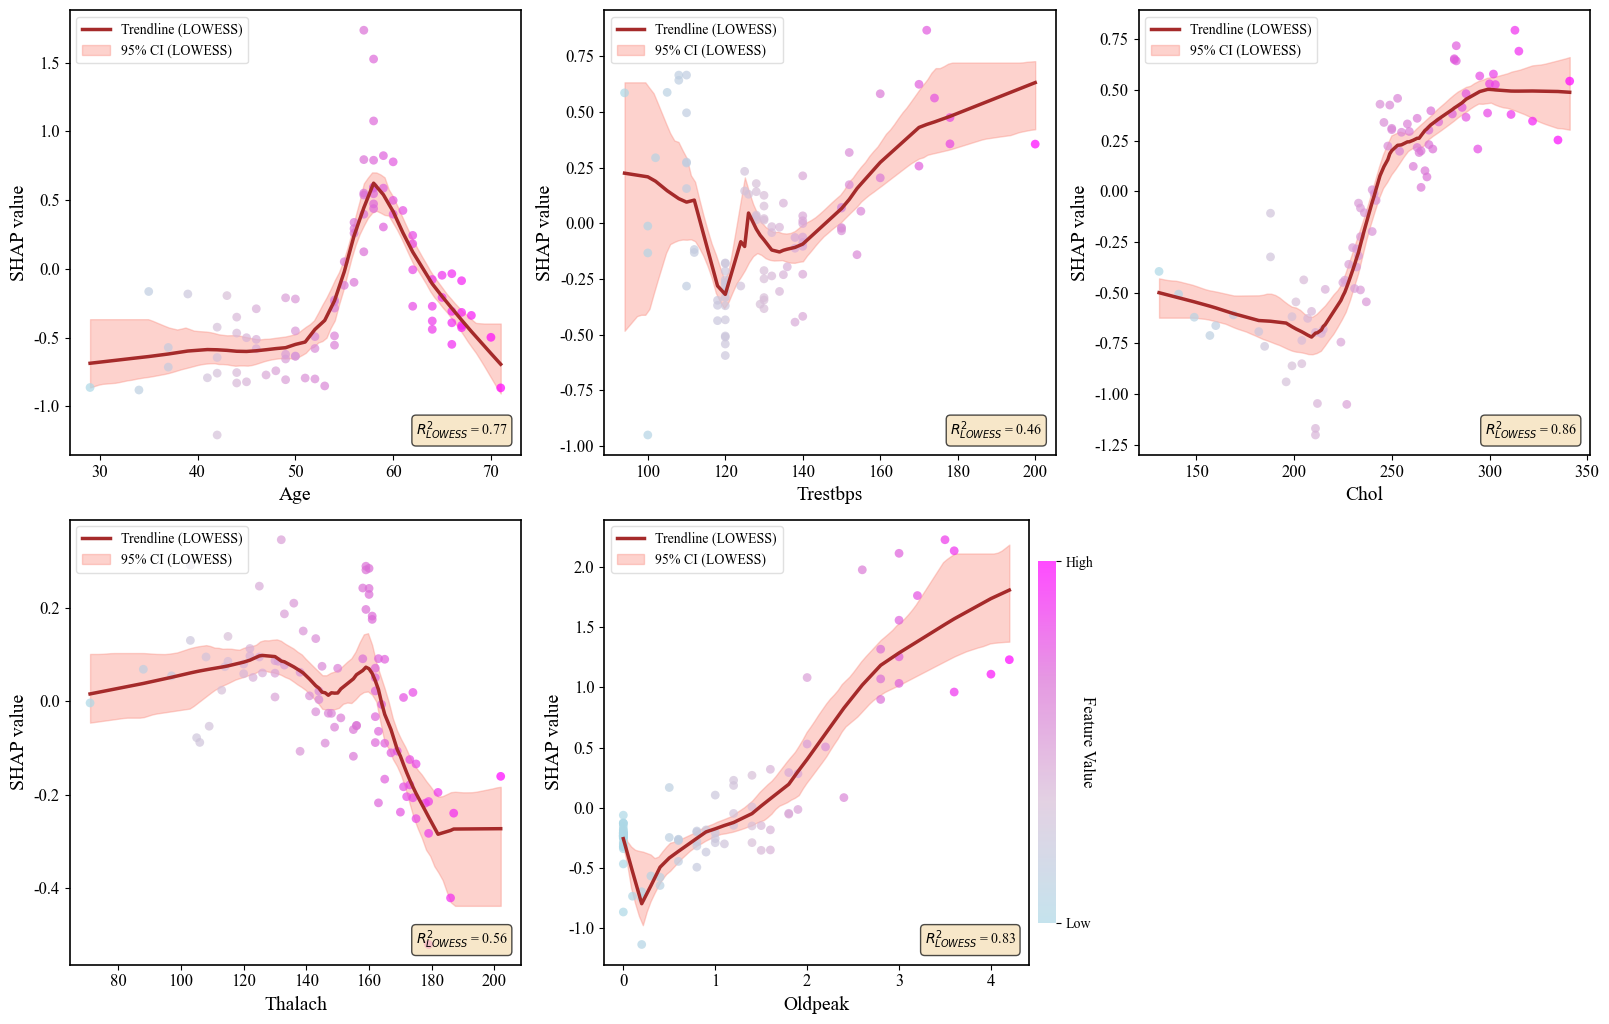

In [8]:
def plot_lowess_with_ci(X_test, shap_values_df, features, ncols=3, nrows=2, lowess_frac=0.4, n_bootstraps=100, random_seed=42, save_as_pdf=False):
    if len(features) == 0:
        print("No features to plot.")
        fig, ax = plt.subplots(figsize=(7, 5.5))
        ax.text(0.5, 0.5, "No features to plot", ha='center', va='center')
        plt.show()
        return
    np.random.seed(random_seed)
    colors_for_cmap = ['#ADD8E6', '#D8BFD8', '#DA70D6', '#FF00FF']
    custom_cmap = LinearSegmentedColormap.from_list("my_custom_cap", colors_for_cmap)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5.5))
    axes = axes.flatten()  
    for idx, feature_to_plot in enumerate(features):
        ax = axes[idx]  
        X_data_orig = X_test[feature_to_plot].values
        Y_data_orig = shap_values_df[feature_to_plot].values
        valid_indices_orig = np.isfinite(X_data_orig) & np.isfinite(Y_data_orig)
        X_data = X_data_orig[valid_indices_orig]
        Y_data = Y_data_orig[valid_indices_orig]
        if len(X_data) < 2:
            ax.text(0.5, 0.5, f"Not enough data: {feature_to_plot}", ha='center', va='center')
            continue
        sort_idx_main = np.argsort(X_data)
        X_sorted_main = X_data[sort_idx_main]
        Y_sorted_main = Y_data[sort_idx_main]
        main_lowess_fit_points = lowess(Y_sorted_main, X_sorted_main, frac=lowess_frac, it=0)
        unique_x_lowess, unique_indices = np.unique(main_lowess_fit_points[:, 0], return_index=True)
        y_for_unique_x_lowess = main_lowess_fit_points[unique_indices, 1]
        lowess_interpolation_function = None
        if len(unique_x_lowess) > 1:
            lowess_interpolation_function = interp1d(unique_x_lowess, y_for_unique_x_lowess,
                                                     kind='linear', fill_value="extrapolate")
        ss_res = np.sum((Y_sorted_main - lowess_interpolation_function(X_sorted_main))**2)
        ss_tot = np.sum((Y_sorted_main - np.mean(Y_sorted_main))**2)
        r_squared_lowess = 1.0 - (ss_res / ss_tot) if ss_tot > np.finfo(float).eps else 0.0
        boot_lowess_preds = []
        plot_ci = False
        if len(X_data) > 1:
            for i in range(n_bootstraps):
                indices = np.random.choice(len(X_data), len(X_data), replace=True)
                X_boot, Y_boot = X_data[indices], Y_data[indices]
                sort_idx_boot = np.argsort(X_boot)
                X_boot_sorted, Y_boot_sorted = X_boot[sort_idx_boot], Y_boot[sort_idx_boot]
                if len(X_boot_sorted) < 2:
                    continue
                current_boot_lowess = lowess(Y_boot_sorted, X_boot_sorted, frac=lowess_frac, it=0)
                unique_x_boot, unique_idx_boot = np.unique(current_boot_lowess[:, 0], return_index=True)
                y_for_unique_x_boot = current_boot_lowess[unique_idx_boot, 1]
                if len(unique_x_boot) > 1:
                    y_interp_boot = np.interp(np.linspace(X_data.min(), X_data.max(), 100), unique_x_boot, y_for_unique_x_boot)
                    boot_lowess_preds.append(y_interp_boot)
            if boot_lowess_preds:
                boot_lowess_preds_array = np.array(boot_lowess_preds)
                ci_lower = np.percentile(boot_lowess_preds_array, 2.5, axis=0)
                ci_upper = np.percentile(boot_lowess_preds_array, 97.5, axis=0)
                plot_ci = True
        scatter_plot = ax.scatter(X_data, Y_data, s=40, c=X_data, cmap=custom_cmap, alpha=0.7, edgecolor='none', zorder=2)
        ax.plot(main_lowess_fit_points[:, 0], main_lowess_fit_points[:, 1], color='#A52A2A', linewidth=2.5, label='Trendline (LOWESS)', zorder=3)
        if plot_ci:
            ax.fill_between(np.linspace(X_data.min(), X_data.max(), 100), ci_lower, ci_upper, color='salmon', alpha=0.35, label='95% CI (LOWESS)', zorder=1)
        ax.set_xlabel(feature_to_plot.capitalize(), fontsize=14)
        ax.set_ylabel("SHAP value", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.spines['top'].set_linewidth(1.2)
        ax.spines['right'].set_linewidth(1.2)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(loc='upper left', fontsize=10, frameon=True, facecolor='white', framealpha=0.7, edgecolor='lightgray')
        ax.text(0.97, 0.03, f"$R^2_{{LOWESS}}$ = {r_squared_lowess:.2f}", transform=ax.transAxes, fontsize=10,
                horizontalalignment='right', verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.7))
        if idx == len(features) - 1:
            cbar = fig.colorbar(scatter_plot, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
            cbar.set_label('Feature Value', rotation=270, labelpad=1, fontsize=12)
            cbar.outline.set_visible(False)
            if len(X_data) > 0:
                cbar.set_ticks([X_data.min(), X_data.max()])
                cbar.set_ticklabels(['Low', 'High'], fontsize=10)
            else:
                cbar.set_ticks([])
    for idx in range(len(features), len(axes)):
        axes[idx].axis('off') 
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.97])
    if save_as_pdf:
        plt.savefig(f"lowess_plots.pdf", format='pdf', bbox_inches='tight', dpi=1200)
    plt.show()
features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # 特征列表，包含要绘制的特征名称
plot_lowess_with_ci(X_test, shap_values_df, features, ncols=3, nrows=2, save_as_pdf=True)